<a href="https://colab.research.google.com/github/vaibhuujaiswal/EmotionClassificationOnAudioVisualData/blob/main/HMI_lab_task_baseline_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting drive with google collab to transfer audio visual dataset

In [73]:
from google.colab import drive
drive.mount('../drive')

Drive already mounted at ../drive; to attempt to forcibly remount, call drive.mount("../drive", force_remount=True).


Libraries to be imported :

In [74]:
import argparse
import imutils
import dlib
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import os
from zipfile import ZipFile
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix #for metrics
import pandas as pd
import librosa

Detection through video :

LBP implementation after which features are extracted from non-overlapping spatial 4*4 blocks!

In [75]:

def get_pixel(image, center, x , y):
    new_value = 0
    try:
        if image[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(image, x, y):
	center = image[x][y]
	val_ar = []
	val_ar.append(get_pixel(image, center, x-1, y-1))
	val_ar.append(get_pixel(image, center, x-1, y))
	val_ar.append(get_pixel(image, center, x-1, y + 1))
	val_ar.append(get_pixel(image, center, x, y + 1))
	val_ar.append(get_pixel(image, center, x + 1, y + 1))
	val_ar.append(get_pixel(image, center, x + 1, y))
	val_ar.append(get_pixel(image, center, x + 1, y-1))
	val_ar.append(get_pixel(image, center, x, y-1))
	power_val= [1, 2, 4, 8, 16, 32, 64, 128]
	val = 0
	for i in range(len(val_ar)):
		val += val_ar[i] * power_val[i]

	return val

def split(array, nrows, ncols):
    r, h = array.shape
    return array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)

def returnAVG(originalMatrix):
  avg= []
  for i in split(originalMatrix, 4, 4):
    avg.append(np.mean(i))
  return avg

def getFrames(fileName):
  capture= cv2.VideoCapture(fileName)
  frameNr= 0
  frame_list= []
  while (True):
      if frameNr % 100 == 0:
        pass
      if frameNr > 1440:
        break
      success, frame= capture.read()
      if success:
          frame= cv2.resize(frame,(120,120))
          frame_list.append(frame)
      else:
          break
      frameNr += 1
  capture.release()
  tempFrames= []
  for i in range(0, len(frame_list), len(frame_list)//4+1):
    tempFrames.append(frame_list[i])
  return tempFrames

Feature Extraction

In [ ]:
dataAverage = []
changedDataAverage = []
path = os.getcwd()
print(path)

for actor in os.listdir('/drive/MyDrive/HMI_code_task/audio_video/'):
    # with ZipFile('./drive/MyDrive/HMI_code_task/audio-video/', 'r') as zipObj:
    #     zipObj.extractall()
        
    for video in os.listdir(f'/drive/MyDrive/HMI_code_task/audio_video/{actor}/'):
        if video == '.DS_Store': #handles uploading case for macbook
            continue
        if int(video[-6:-4]) <= 20 and int(video[0:2]) == 1 and video.find('.mp4') != -1: #Using the first twenty actors for training and choosing from video
            print(video)
            videoName = f"/drive/MyDrive/HMI_code_task/audio_video/{actor}/{video}"

            try:
                listFrames= getFrames(videoName)
                videoAVGs= []
                for eachFrame in listFrames:
                    gray= cv2.cvtColor(eachFrame, cv2.COLOR_BGR2GRAY) #convert frame to grayscale
                    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #using opencv's haarcascade function
                    #fer could also have been used for the same.
                    faces = faceCascade.detectMultiScale(gray, scaleFactor = 1.05, minNeighbors = 6, minSize=(30, 30))
                    
                    image_frame = None
                    for (x, y, w, h) in faces:
                        cv2.rectangle(eachFrame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        image_frame = eachFrame[y:y + h, x:x + w]

                    #resize image to 128 * 128 
                    color_frame_bgr = image_frame
                    color_frame_bgr = cv2.resize(color_frame_bgr, (128, 128))
                    
                    #convert image to black and white
                    height, width, _= color_frame_bgr.shape
                    gray_frame= cv2.cvtColor(color_frame_bgr, cv2.COLOR_BGR2GRAY)
                    frame_LBP = np.zeros((height, width), np.uint8)
                    
                    #Post aligning Local Binary Pattern
                    for i in range(0, height):
                        for j in range(0, width):
                            frame_LBP[i, j] = lbp_calculated_pixel(gray_frame, i, j)
                    
                    videoAVGs.append(returnAVG(frame_LBP))

                dataAverage.append(videoAVGs)
                changedDataAverage.append(video[6:8])
            except Exception as E:
                print("Error in feature extraction")
                pass


dataAverage = np.array(dataAverage)
dataAverage = np.reshape(dataAverage, (-1, 4*1024))
dataAverage = dataAverage[:1200,:]
dataAverage.shape

changedDataAverage = np.array(changedDataAverage)
changedDataAverage = changedDataAverage[:1200,]
changedDataAverage.shape

baseline_video_train_x = dataAverage[:1200,]
baseline_video_train_y= changedDataAverage[:1200,]


SVM is learned for classification :

In [ ]:
dataAverage = []
changedDataAverage = []

for actor in os.listdir('/drive/MyDrive/HMI_code_task/audio_video/'):
  for video in os.listdir(f'/drive/MyDrive/HMI_code_task/audio_video/{actor}'):
    if video == '.DS_Store':
            continue
    if int(video[-6:-4]) > 20 and video[0:2] == '01' and video.find('.mp4') != -1:
      videoName= f"/drive/MyDrive/HMI_code_task/audio_video/{actor}/{video}"
      print(video)
      try:
        listFrames = getFrames(videoName)
        videoAVGs = []
        for eachFrame in listFrames:
            gray= cv2.cvtColor(eachFrame, cv2.COLOR_BGR2GRAY)
            faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
            faces = faceCascade.detectMultiScale(gray, scaleFactor=1.05,minNeighbors=6, minSize=(30, 30))
            
            image_frame= None
            for (x, y, w, h) in faces:
                cv2.rectangle(eachFrame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                image_frame= eachFrame[y:y + h, x:x + w]

            color_frame_bgr= image_frame
            color_frame_bgr= cv2.resize(color_frame_bgr, (128, 128))
            
            height, width, _= color_frame_bgr.shape
            gray_frame= cv2.cvtColor(color_frame_bgr, cv2.COLOR_BGR2GRAY)
            frame_LBP= np.zeros((height, width), np.uint8)
            
            for i in range(0, height):
              for j in range(0, width):
                frame_LBP[i, j]= lbp_calculated_pixel(gray_frame, i, j)
            
            videoAVGs.append(returnAVG(frame_LBP))
        dataAverage.append(videoAVGs)
        changedDataAverage.append(video[6:8])
      except Exception as E:
        pass


dataAverage= np.array(dataAverage)
dataAverage= np.reshape(dataAverage, (-1, 4*1024))
dataAverage= dataAverage[:240,:]
dataAverage.shape

changedDataAverage = np.array(changedDataAverage)
changedDataAverage = changedDataAverage[:240,]
changedDataAverage.shape

baseline_video_test_x = dataAverage
baseline_video_test_y= changedDataAverage

In [98]:
from sklearn.model_selection import train_test_split

x_train_testVideo, x_test_testVideo, y_train_testVideo, y_test_testVideo = train_test_split(dataAverage, changedDataAverage, test_size= 0.2, shuffle= True)

[[255.    255.    255.    ... 143.    143.    164.   ]
 [255.    255.    255.    ... 143.    141.5   164.   ]
 [255.    255.    255.    ... 143.    141.5   164.   ]
 ...
 [255.    255.    255.    ... 143.    143.    164.   ]
 [255.    255.    254.    ...  82.625 108.25  171.75 ]
 [255.    255.    255.    ... 200.    219.5   109.75 ]]


Dimension reduction using PCA

In [94]:
pca= PCA(n_components= 30)
x_train= pca.fit_transform(baseline_video_train_x)
x_test= pca.transform(baseline_video_test_x)

Model *Training*

In [95]:
svm = SVC()
svm.fit(x_train, baseline_video_train_y)

SVC()

SVM metrics (using SVM skit learn)

In [96]:
y_Pred = svm.predict(x_test)
print("SVM")
print("SVM Testing Accuracy : ", accuracy_score(baseline_video_test_y, y_Pred)*100)
print("SVM Precision Score : ", precision_score(baseline_video_test_y, y_Pred, average='macro')*100)
print("SVM Recall Score : ", recall_score(baseline_video_test_y, y_Pred, average='macro')*100)
print("SVM F1 Score : ", f1_score(baseline_video_test_y, y_Pred, average='macro'))
print("SVM Confusion Matrix\n", confusion_matrix(baseline_video_test_y, y_Pred))

SVM
SVM Testing Accuracy :  27.350427350427353
SVM Precision Score :  28.62251905015063
SVM Recall Score :  25.942887931034488
SVM F1 Score :  0.23631163979864725
SVM Confusion Matrix
 [[ 2 11  0  0  0  0  0  3]
 [ 0 21  6  1  1  0  0  3]
 [ 0 11 21  0  0  0  0  0]
 [ 3  9  2  0  5  2  0  8]
 [ 4  7  1  0  5 10  0  5]
 [ 4  9  0  2  1  7  1  8]
 [ 5  3  0  0  6  7  4  7]
 [ 6 10  0  0  1  7  1  4]]


##AUDIO through smile. 

Please note that openEAR was no longer available for using. The github repository has not been present and maybe has been removed due to licensing issues. Opensmile.git can be used for the same.

Installation with help of : https://audeering.github.io/opensmile/get-started.html

In [108]:
!pip install Moviepy

Data Extraction and prepping

In [126]:
"https://towardsdatascience.com/speech-emotion-recognition-using-ravdess-audio-dataset-ce19d162690#:~:text=It%20is%20a%20system%20through,field%20or%20customer%20call%20centers."


emotionList = []
actorList = []
file_path = []

for actor in os.listdir('/drive/MyDrive/HMI_code_task/audio_video/'):
    for video in os.listdir(f'/drive/MyDrive/HMI_code_task/audio_video/{actor}/'):
        if video == '.DS_Store':
            continue
        if video[0:2] == '01' and video.find(".mp4") != -1:
            filename= f"/drive/MyDrive/HMI_code_task/audio_video/{actor}/{video}"
            part = filename.split('.')[0].split('-')
            emotionList.append(int(part[2]))
            actorList.append(int(part[6]))
            file_path.append(f"/drive/MyDrive/HMI_code_task/audio_video/{actor}/{video}")



audio_df = pd.DataFrame(emotionList)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([audio_df, pd.DataFrame(actorList)], axis=1)
audio_df.columns = ['emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)


Audio Feature **Extraction**

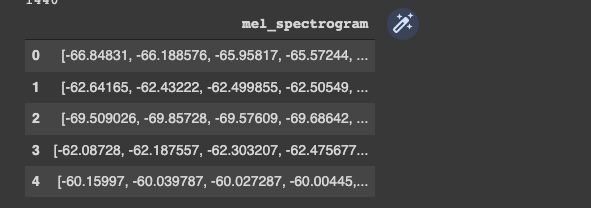

In [ ]:
import librosa

df = pd.DataFrame(columns=['mel_spectrogram'])
counter = 0
for index, path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type = 'kaiser_fast',duration = 3,sr = 44100,offset = 0.5)
    print(path)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1
print(len(df))
df.head()


###Split train and test

In [139]:
train,test = train_test_split(df, test_size = 0.2, random_state = 0)

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2]
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2]

In [140]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

##**Label** Encoder :

In [ ]:
!pip install keras.utils
from keras.utils import to_categorical


In [ ]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
